# Hunyuan-MT-7B Ollama 테스트 (비동기)
## MES 질문/프롬프트 한국어 ↔ 영어 번역

### 특징
- **AsyncClient 사용** - 비동기 처리
- **스트리밍** - 실시간 응답 수신
- **텍스트 추출 후 번역** - JSON 값만 추출하여 번역 후 재구성
- **Tencent Hunyuan-MT-7B** - WMT25 대회 1위 텍스트 번역 모델

## 1. 라이브러리 임포트

In [7]:
from ollama import AsyncClient
import asyncio
import time
import json
import re
from typing import Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import psutil
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("✓ Libraries loaded")

✓ Libraries loaded


## 2. Ollama 설정

In [8]:
# ⚠️ 여기를 실제 환경에 맞게 수정하세요
OLLAMA_HOST = "http://192.168.1.70:11434"
MODEL_NAME = "huihui_ai/hunyuan-mt-abliterated:7b"

print(f"Ollama Host: {OLLAMA_HOST}")
print(f"Model: {MODEL_NAME}")
print("\nModel Info:")
print("- WMT25 대회 30/31 언어 카테고리 1위")
print("- 한국어 ↔ 영어 텍스트 번역")
print("- 7B 파라미터 모델")

Ollama Host: http://192.168.1.70:11434
Model: huihui_ai/hunyuan-mt-abliterated:7b

Model Info:
- WMT25 대회 30/31 언어 카테고리 1위
- 한국어 ↔ 영어 텍스트 번역
- 7B 파라미터 모델


## 3. JSON 처리 헬퍼 함수

In [9]:
def extract_text_from_json(obj: Any, path: str = "") -> list:
    """
    JSON 객체에서 번역 가능한 텍스트 추출
    
    Returns:
        List of tuples: [(path, text), ...]
    """
    results = []
    
    if isinstance(obj, dict):
        for key, value in obj.items():
            new_path = f"{path}.{key}" if path else key
            results.extend(extract_text_from_json(value, new_path))
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            new_path = f"{path}[{i}]"
            results.extend(extract_text_from_json(item, new_path))
    elif isinstance(obj, str) and obj.strip():  # 문자열이고 비어있지 않으면
        results.append((path, obj))
    
    return results


def reconstruct_json(original: Any, translations: dict, path: str = "") -> Any:
    """
    원본 JSON 구조에 번역된 텍스트 적용
    
    Args:
        original: 원본 JSON 객체
        translations: {path: translated_text} 딕셔너리
        path: 현재 경로
    
    Returns:
        번역된 JSON 객체
    """
    if isinstance(original, dict):
        result = {}
        for key, value in original.items():
            new_path = f"{path}.{key}" if path else key
            result[key] = reconstruct_json(value, translations, new_path)
        return result
    elif isinstance(original, list):
        result = []
        for i, item in enumerate(original):
            new_path = f"{path}[{i}]"
            result.append(reconstruct_json(item, translations, new_path))
        return result
    elif isinstance(original, str):
        # 번역된 텍스트가 있으면 사용, 없으면 원본 유지
        return translations.get(path, original)
    else:
        return original


print("✓ JSON helper functions defined")

✓ JSON helper functions defined


## 4. Hunyuan-MT 텍스트 번역 함수

In [10]:
async def translate_text_with_hunyuan(text: str, target_language: str, glossary: dict = None) -> dict:
    """
    Hunyuan-MT를 사용한 텍스트 번역
    
    Args:
        text: 번역할 텍스트
        target_language: 타겟 언어 ("English" 또는 "Korean")
        glossary: 용어집 {원문: 번역}
    
    Returns:
        Dict: {'translated_text': str, 'inference_time': float, ...}
    """
    
    # 프롬프트 구성
    prompt_parts = []
    
    # 용어집이 있으면 추가
    if glossary:
        glossary_str = "\n".join([f"- {k}: {v}" for k, v in glossary.items()])
        prompt_parts.append(f"Glossary:\n{glossary_str}\n")
    
    # Hunyuan-MT 공식 프롬프트
    prompt_parts.append(f"Translate the following segment into {target_language}, without additional explanation.\n")
    prompt_parts.append(text)
    
    user_message = "\n".join(prompt_parts)
    
    start_time = time.time()
    
    try:
        client = AsyncClient(host=OLLAMA_HOST)
        
        response_stream = await client.chat(
            model=MODEL_NAME,
            messages=[
                {'role': 'user', 'content': user_message}
            ],
            stream=True,
            options={
                'top_k': 20,
                'top_p': 0.6,
                'temperature': 0.7,
                'repetition_penalty': 1.05
            }
        )
        
        full_response = ""
        
        async for chunk in response_stream:
            if chunk.get('done'):
                break
            if 'message' in chunk and 'content' in chunk['message']:
                full_response += chunk['message']['content']
        
        inference_time = time.time() - start_time
        
        # 번역 결과 정리 (앞뒤 공백 제거)
        translated_text = full_response.strip()
        
        return {
            'translated_text': translated_text,
            'inference_time': inference_time,
            'error': None
        }
        
    except Exception as e:
        return {
            'translated_text': None,
            'inference_time': time.time() - start_time,
            'error': str(e)
        }


print("✓ Text translation function defined")

✓ Text translation function defined


## 5. JSON 번역 함수 (텍스트 추출 → 번역 → 재구성)

In [11]:
async def translate_json_with_hunyuan(source: Dict, target_language: str, context: Dict = None) -> Dict:
    """
    JSON 객체를 Hunyuan-MT로 번역
    
    Process:
    1. JSON에서 텍스트 값들 추출
    2. 각 텍스트를 개별적으로 번역
    3. 원본 JSON 구조에 번역 결과 적용
    
    Args:
        source: 번역할 JSON 데이터
        target_language: 타겟 언어
        context: {glossary, tone, context}
    
    Returns:
        번역 결과 및 성능 메트릭
    """
    
    mem_before = psutil.Process().memory_info().rss / 1024**2
    start_time = time.time()
    
    try:
        # 1. JSON에서 텍스트 추출
        text_items = extract_text_from_json(source)
        
        if not text_items:
            return {
                'translation': source,
                'raw_response': None,
                'inference_time': 0,
                'tokens': 0,
                'tokens_per_second': 0,
                'memory_used_mb': 0,
                'error': 'No text to translate'
            }
        
        # 2. 각 텍스트 번역
        glossary = context.get('glossary') if context else None
        translations = {}
        total_tokens = 0
        
        for path, text in text_items:
            result = await translate_text_with_hunyuan(text, target_language, glossary)
            
            if result['error']:
                translations[path] = text  # 에러시 원본 유지
            else:
                translations[path] = result['translated_text']
                total_tokens += len(result['translated_text'].split())
        
        # 3. JSON 재구성
        translated_json = reconstruct_json(source, translations)
        
        inference_time = time.time() - start_time
        mem_after = psutil.Process().memory_info().rss / 1024**2
        tokens_per_second = total_tokens / inference_time if inference_time > 0 else 0
        
        return {
            'translation': translated_json,
            'raw_response': json.dumps(translated_json, ensure_ascii=False),
            'inference_time': inference_time,
            'tokens': total_tokens,
            'tokens_per_second': tokens_per_second,
            'memory_used_mb': mem_after - mem_before,
            'text_count': len(text_items),
            'error': None
        }
        
    except Exception as e:
        return {
            'translation': None,
            'raw_response': None,
            'inference_time': time.time() - start_time,
            'tokens': 0,
            'tokens_per_second': 0,
            'memory_used_mb': 0,
            'text_count': 0,
            'error': str(e)
        }


print("✓ JSON translation function defined")

✓ JSON translation function defined


## 6. 테스트 데이터셋

In [30]:
test_cases = [
    # 생산 관련
    {
        "category": "production",
        "source": {"question": "오늘 생산 계획을 보여주세요."},
        "target_language": "English",
        "context": {
            "glossary": {
                "생산 계획": "production schedule"
            }
        }
    },
    {
        "category": "production",
        "source": {"question": "작업지시 목록을 조회해주세요."},
        "target_language": "English",
        "context": {
            "glossary": {
                "작업지시": "Work Order"
            }
        }
    },
    # 품질 관련
    {
        "category": "quality",
        "source": {"question": "불량률이 5% 이상인 제품을 찾아주세요."},
        "target_language": "English",
        "context": {
            "glossary": {
                "불량률": "Defect rate"
            }
        }
    },
    # 재고 관련
    {
        "category": "inventory",
        "source": {"question": "현재 재고 수량을 확인해주세요."},
        "target_language": "English",
        "context": {
            "glossary": {
                "재고": "inventory"
            }
        }
    },
    # 복잡한 쿼리
    {
        "category": "complex",
        "source": {
            "question": "계획일자가 2024년 10월 23일 23시 11분 23초 이후이고, 생산일자가 '2025-01-01 12:34:56' 이후인 작업지시 목록을 조회해주세요. 작업지시 키, 작업지시 번호, 지시 유형, 지시상태, 품목 키, 품목 코드, 품목 명, 품목 유형, 지시 수량, 라우팅 키, 라우팅 코드, 라우팅 명, 계획 시작일자, 계획 종료일자, 생산 시작일자, 생산 종료일자, 비고, 지시 유형명, 지시 상태명의 형태로 조회해주세요."
        },
        "target_language": "English",
        "context": {
            "glossary": {
                "작업지시": "Production Order",
                "품목": "Item",
                "라우팅": "Routing"
            }
        }
    },
    # 역방향 번역
    {
        "category": "reverse",
        "source": {"question": "Show me today's production schedule."},
        "target_language": "Korean",
        "context": None
    }
]

print(f"✓ {len(test_cases)} test cases loaded")

✓ 6 test cases loaded


## 7. 단일 테스트

In [31]:
# 첫 번째 테스트 케이스로 단일 테스트
test = test_cases[0]

print("Source:")
print(json.dumps(test['source'], indent=2, ensure_ascii=False))
print(f"\nTarget: {test['target_language']}")

result = await translate_json_with_hunyuan(
    test['source'], 
    test['target_language'],
    test.get('context')
)

if not result.get('error'):
    print("\nTranslation:")
    print(json.dumps(result['translation'], indent=2, ensure_ascii=False))
    print(f"\n⏱️  {result['inference_time']:.2f}s | 🚀 {result['tokens_per_second']:.1f} tok/s | 📝 {result['text_count']} texts")
else:
    print(f"\n❌ Error: {result['error']}")

Source:
{
  "question": "오늘 생산 계획을 보여주세요."
}

Target: English

Translation:
{
  "question": "Today, please show us the production schedule."
}

⏱️  0.17s | 🚀 42.0 tok/s | 📝 1 texts


## 8. 배치 테스트

In [32]:
results = []

print(f"Running {len(test_cases)} translation tests...\n")

for i, test in enumerate(test_cases, 1):
    print(f"[{i}/{len(test_cases)}] {test['category']} - {test['target_language']}")
    
    result = await translate_json_with_hunyuan(
        test['source'],
        test['target_language'],
        test.get('context')
    )
    
    results.append({
        'test_id': i,
        'category': test['category'],
        'target_language': test['target_language'],
        'source': test['source'],
        'translation': result.get('translation'),
        'inference_time': result['inference_time'],
        'tokens': result['tokens'],
        'tokens_per_second': result['tokens_per_second'],
        'memory_used_mb': result['memory_used_mb'],
        'text_count': result.get('text_count', 0),
        'success': result.get('error') is None
    })
    
    status = "✓" if result.get('error') is None else "✗"
    print(f"  {status} {result['inference_time']:.2f}s | {result['tokens_per_second']:.1f} tok/s | {result.get('text_count', 0)} texts")
    
    if result.get('error'):
        print(f"  Error: {result['error']}")
    
    print()

print(f"\n✓ Completed {len(results)} tests")

Running 6 translation tests...

[1/6] production - English
  ✓ 0.13s | 52.6 tok/s | 1 texts

[2/6] production - English
  ✓ 0.17s | 40.9 tok/s | 1 texts

[3/6] quality - English
  ✓ 0.17s | 64.3 tok/s | 1 texts

[4/6] inventory - English
  ✓ 0.15s | 41.0 tok/s | 1 texts

[5/6] complex - English
  ✓ 1.10s | 75.8 tok/s | 1 texts

[6/6] reverse - Korean
  ✓ 0.18s | 22.1 tok/s | 1 texts


✓ Completed 6 tests


## 9. 결과 분석

In [29]:
if len(results) > 0:
    df = pd.DataFrame(results)
    
    print("="*60)
    print("성능 요약")
    print("="*60)
    print(f"총 테스트: {len(df)}")
    print(f"성공: {df['success'].sum()}")
    print(f"실패: {(~df['success']).sum()}")
    print(f"\n평균 추론 시간: {df['inference_time'].mean():.2f}s")
    print(f"평균 속도: {df['tokens_per_second'].mean():.1f} tokens/s")
    print(f"평균 메모리 사용: {df['memory_used_mb'].mean():.1f} MB")
    print(f"평균 텍스트 개수: {df['text_count'].mean():.1f}")
    
    print("\n" + "="*60)
    print("카테고리별 통계")
    print("="*60)
    
    category_stats = df.groupby('category').agg({
        'inference_time': ['mean', 'min', 'max'],
        'tokens_per_second': 'mean',
        'text_count': 'mean',
        'success': 'sum'
    }).round(2)
    
    print(category_stats)

성능 요약
총 테스트: 6
성공: 6
실패: 0

평균 추론 시간: 0.31s
평균 속도: 52.3 tokens/s
평균 메모리 사용: 0.3 MB
평균 텍스트 개수: 1.0

카테고리별 통계
           inference_time             tokens_per_second text_count success
                     mean   min   max              mean       mean     sum
category                                                                  
complex              1.08  1.08  1.08             76.58        1.0       1
inventory            0.12  0.12  0.12             51.37        1.0       1
production           0.13  0.12  0.15             52.30        1.0       2
quality              0.17  0.17  0.17             62.92        1.0       1
reverse              0.22  0.22  0.22             18.09        1.0       1


## 10. 시각화

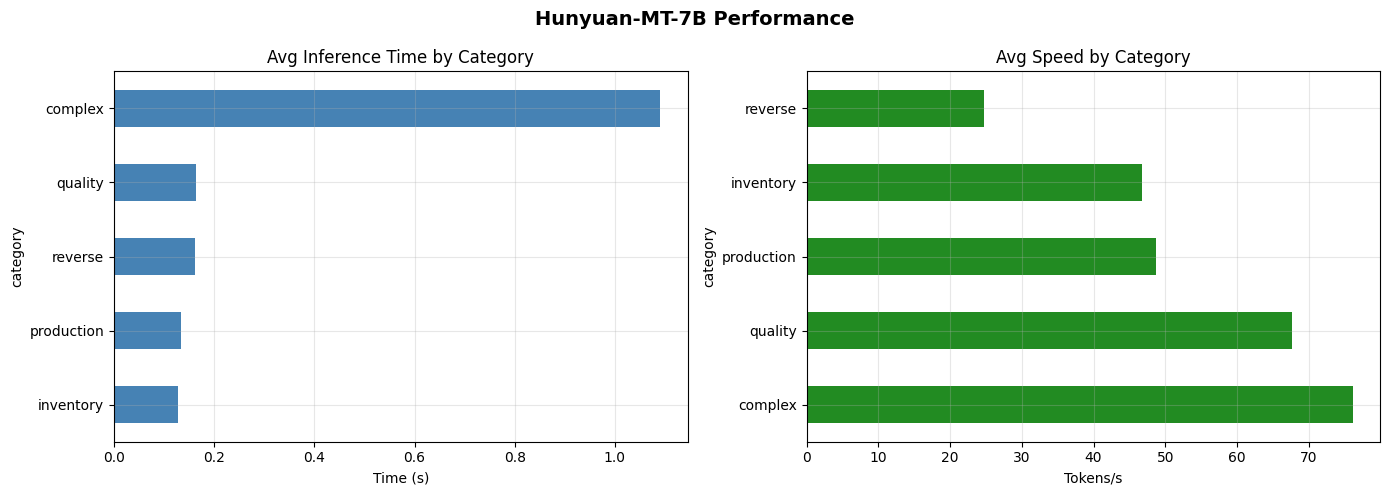

In [16]:
if len(results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f'Hunyuan-MT-7B Performance', fontsize=14, fontweight='bold')
    
    # 카테고리별 시간
    df.groupby('category')['inference_time'].mean().sort_values().plot(
        kind='barh', ax=axes[0], color='steelblue'
    )
    axes[0].set_xlabel('Time (s)')
    axes[0].set_title('Avg Inference Time by Category')
    axes[0].grid(True, alpha=0.3)
    
    # 카테고리별 속도
    df.groupby('category')['tokens_per_second'].mean().sort_values(ascending=False).plot(
        kind='barh', ax=axes[1], color='forestgreen'
    )
    axes[1].set_xlabel('Tokens/s')
    axes[1].set_title('Avg Speed by Category')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 11. 결과 저장

In [ ]:
if len(results) > 0:
    # CSV 저장
    df.to_csv('hunyuan_mt_7b_async_results.csv', index=False, encoding='utf-8-sig')
    
    # JSON 요약
    summary = {
        'host': OLLAMA_HOST,
        'model': MODEL_NAME,
        'mode': 'async',
        'samples': len(df),
        'avg_time': float(df['inference_time'].mean()),
        'avg_speed': float(df['tokens_per_second'].mean()),
        'success_rate': float(df['success'].sum() / len(df)),
        'categories': {}
    }
    
    for cat in df['category'].unique():
        cat_df = df[df['category'] == cat]
        summary['categories'][cat] = {
            'count': len(cat_df),
            'avg_time': float(cat_df['inference_time'].mean()),
            'avg_speed': float(cat_df['tokens_per_second'].mean()),
            'success_rate': float(cat_df['success'].sum() / len(cat_df))
        }
    
    with open('hunyuan_mt_7b_async_summary.json', 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    print("✓ Results saved:")
    print("  - hunyuan_mt_7b_async_results.csv")
    print("  - hunyuan_mt_7b_async_summary.json")

## 12. 커스텀 테스트

In [33]:
# 직접 입력하여 테스트
custom_source = {
    "question": "'PD202509010017' 작업지시의 일별 생산실적 수량을 알려주세요."
}
custom_context = {
    "glossary": {
        "작업지시": "Production Order",
        "계획일자": "Planned Date",
        "생산일자": "Production Date"
    }
}

print("Custom Test:")
print(json.dumps(custom_source, indent=2, ensure_ascii=False))

result = await translate_json_with_hunyuan(
    custom_source, 
    "English",
    context=custom_context
)

if not result.get('error'):
    print("\nTranslation:")
    print(json.dumps(result['translation'], indent=2, ensure_ascii=False))
    print(f"\n⏱️  {result['inference_time']:.2f}s | 🚀 {result['tokens_per_second']:.1f} tok/s")
else:
    print(f"\n❌ {result['error']}")

Custom Test:
{
  "question": "'PD202509010017' 작업지시의 일별 생산실적 수량을 알려주세요."
}

Translation:
{
  "question": "Please provide the daily production quantity for the 'PD202509010017' Production Order."
}

⏱️  0.32s | 🚀 34.8 tok/s


## 13. 모델 정보

### Hunyuan-MT-7B:
- **WMT25 대회** 30/31 언어 카테고리 1위
- **텍스트 번역 전문** - JSON 구조가 아닌 순수 텍스트 번역
- **7B 파라미터**

### 번역 프로세스:
1. JSON에서 문자열 값 추출
2. 각 텍스트를 개별적으로 번역
3. 원본 JSON 구조에 번역 결과 재구성

### 프롬프트 형식:
```
Translate the following segment into <target_language>, without additional explanation.

<text>
```

### 권장 파라미터:
```python
{
    "top_k": 20,
    "top_p": 0.6,
    "repetition_penalty": 1.05,
    "temperature": 0.7
}
```

### 참고:
- https://huggingface.co/tencent/Hunyuan-MT-7B